<a href="https://colab.research.google.com/github/brunofernandez-blip/TFG/blob/main/MCMC(NB)_Opinions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

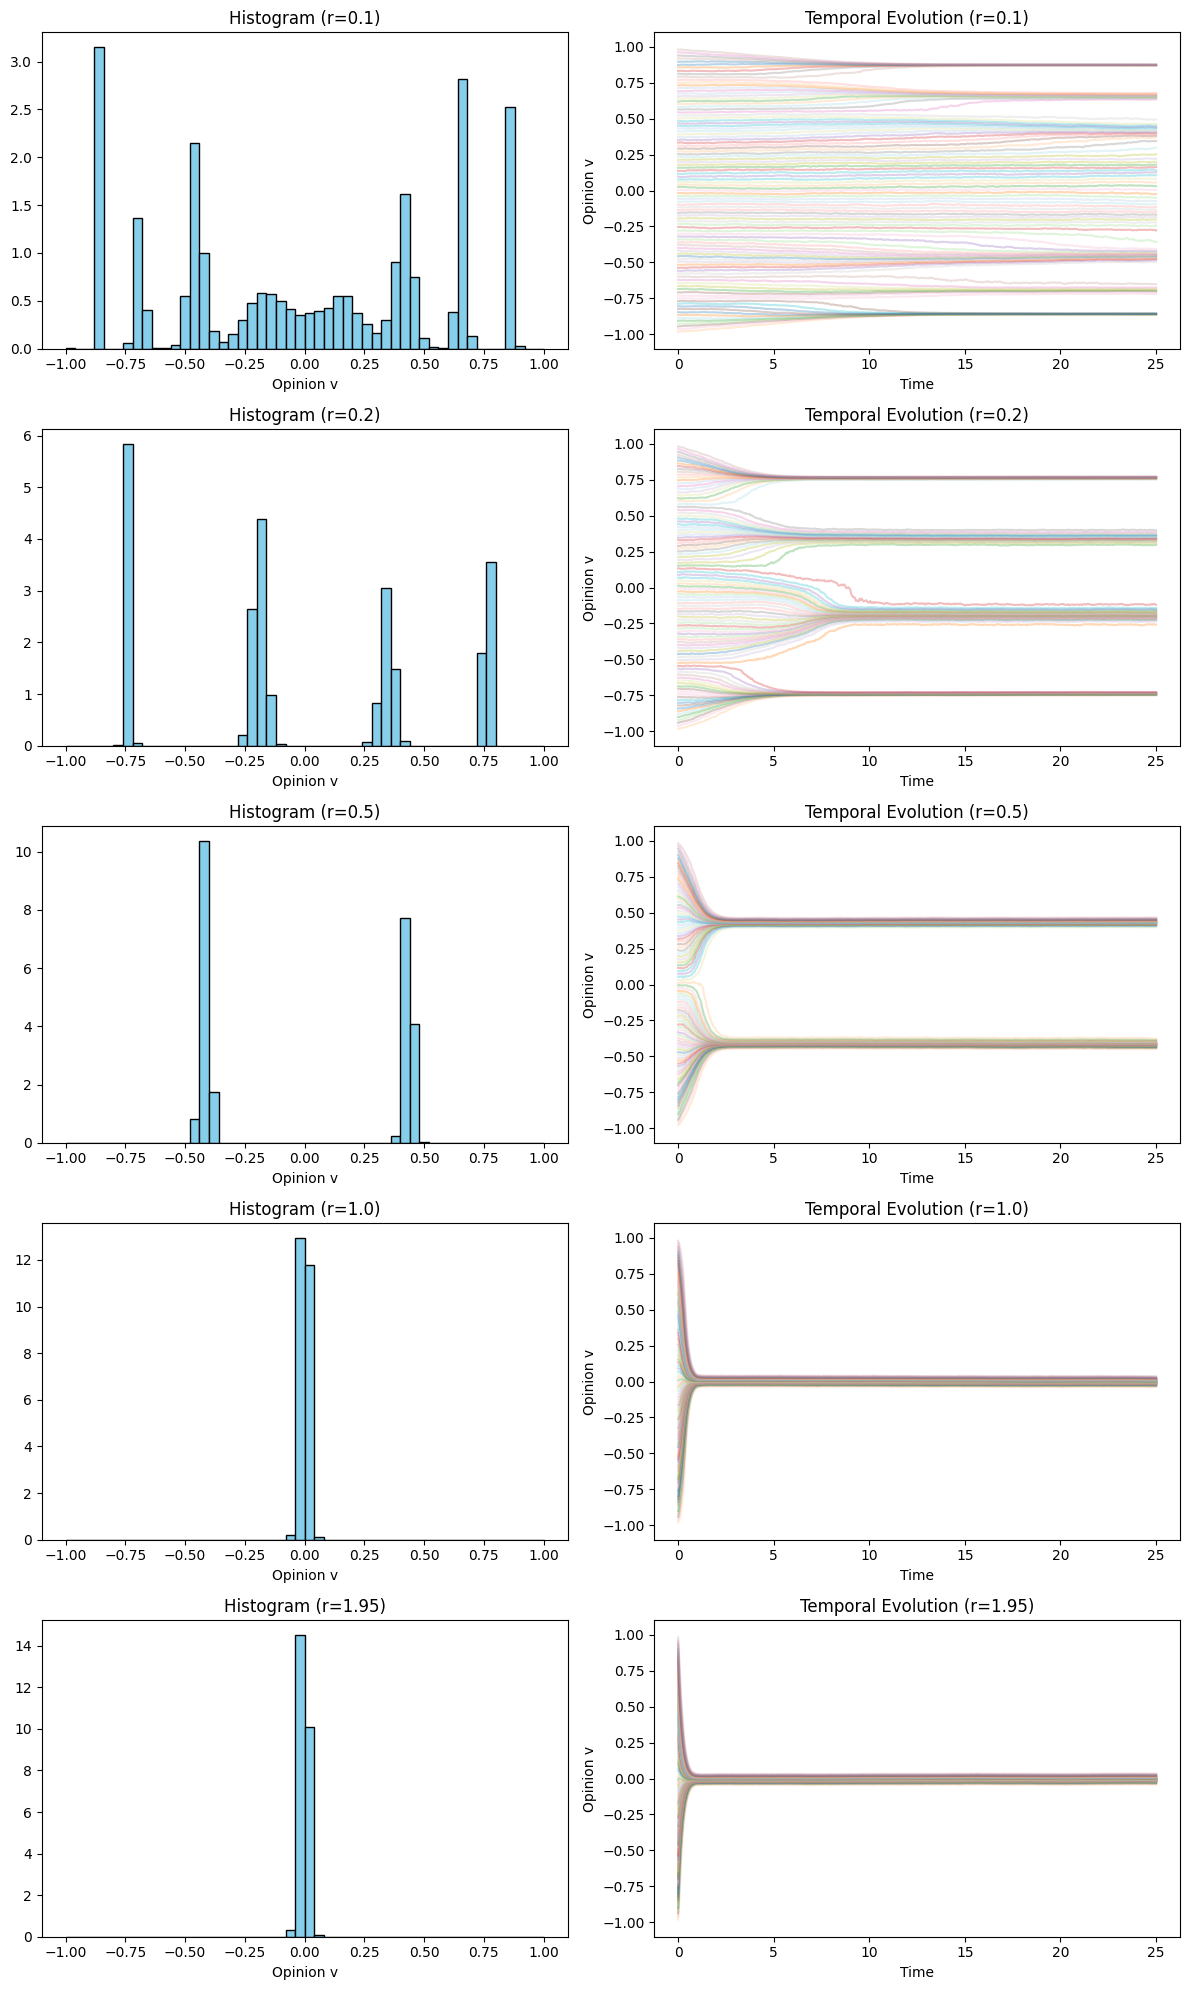

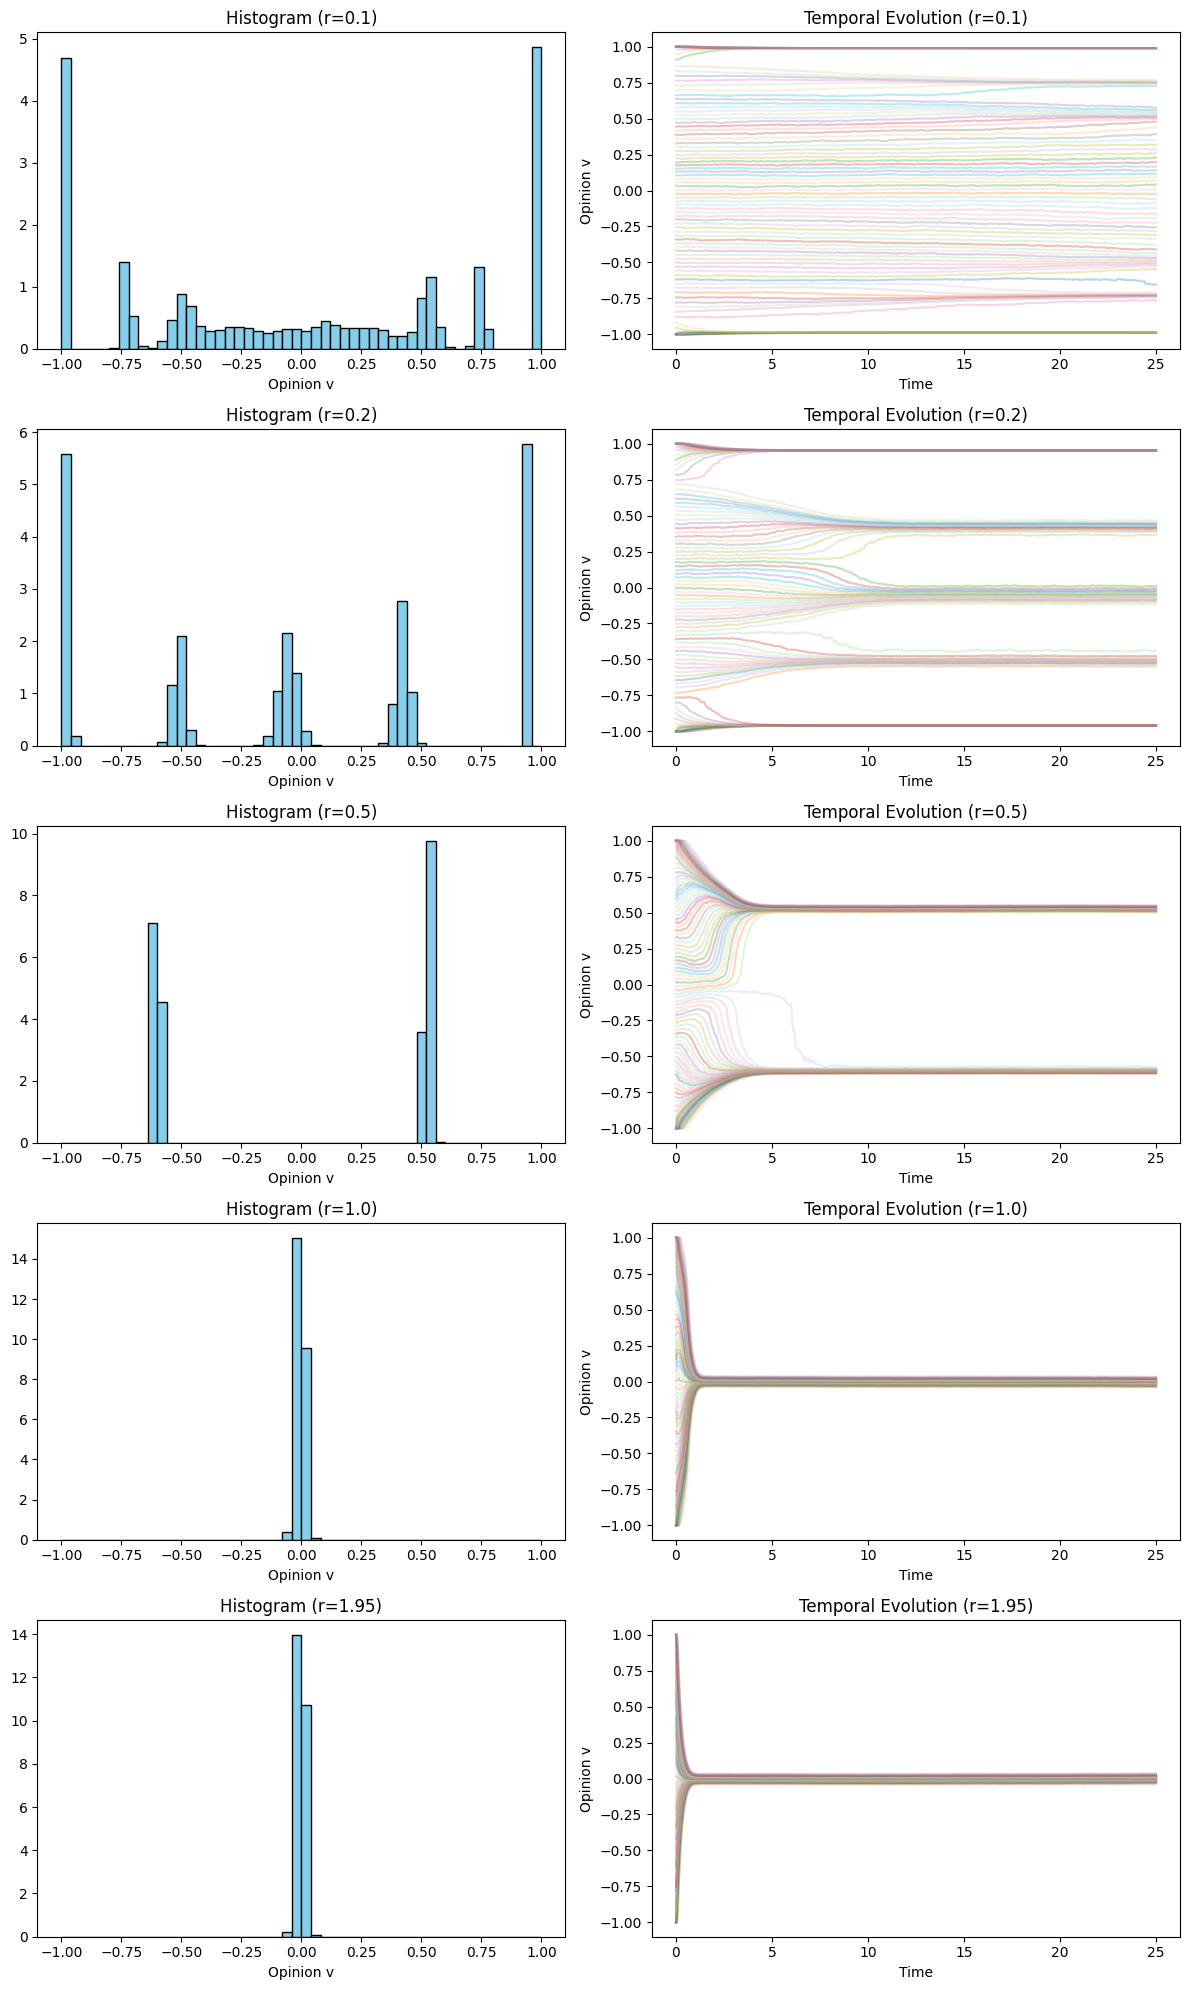

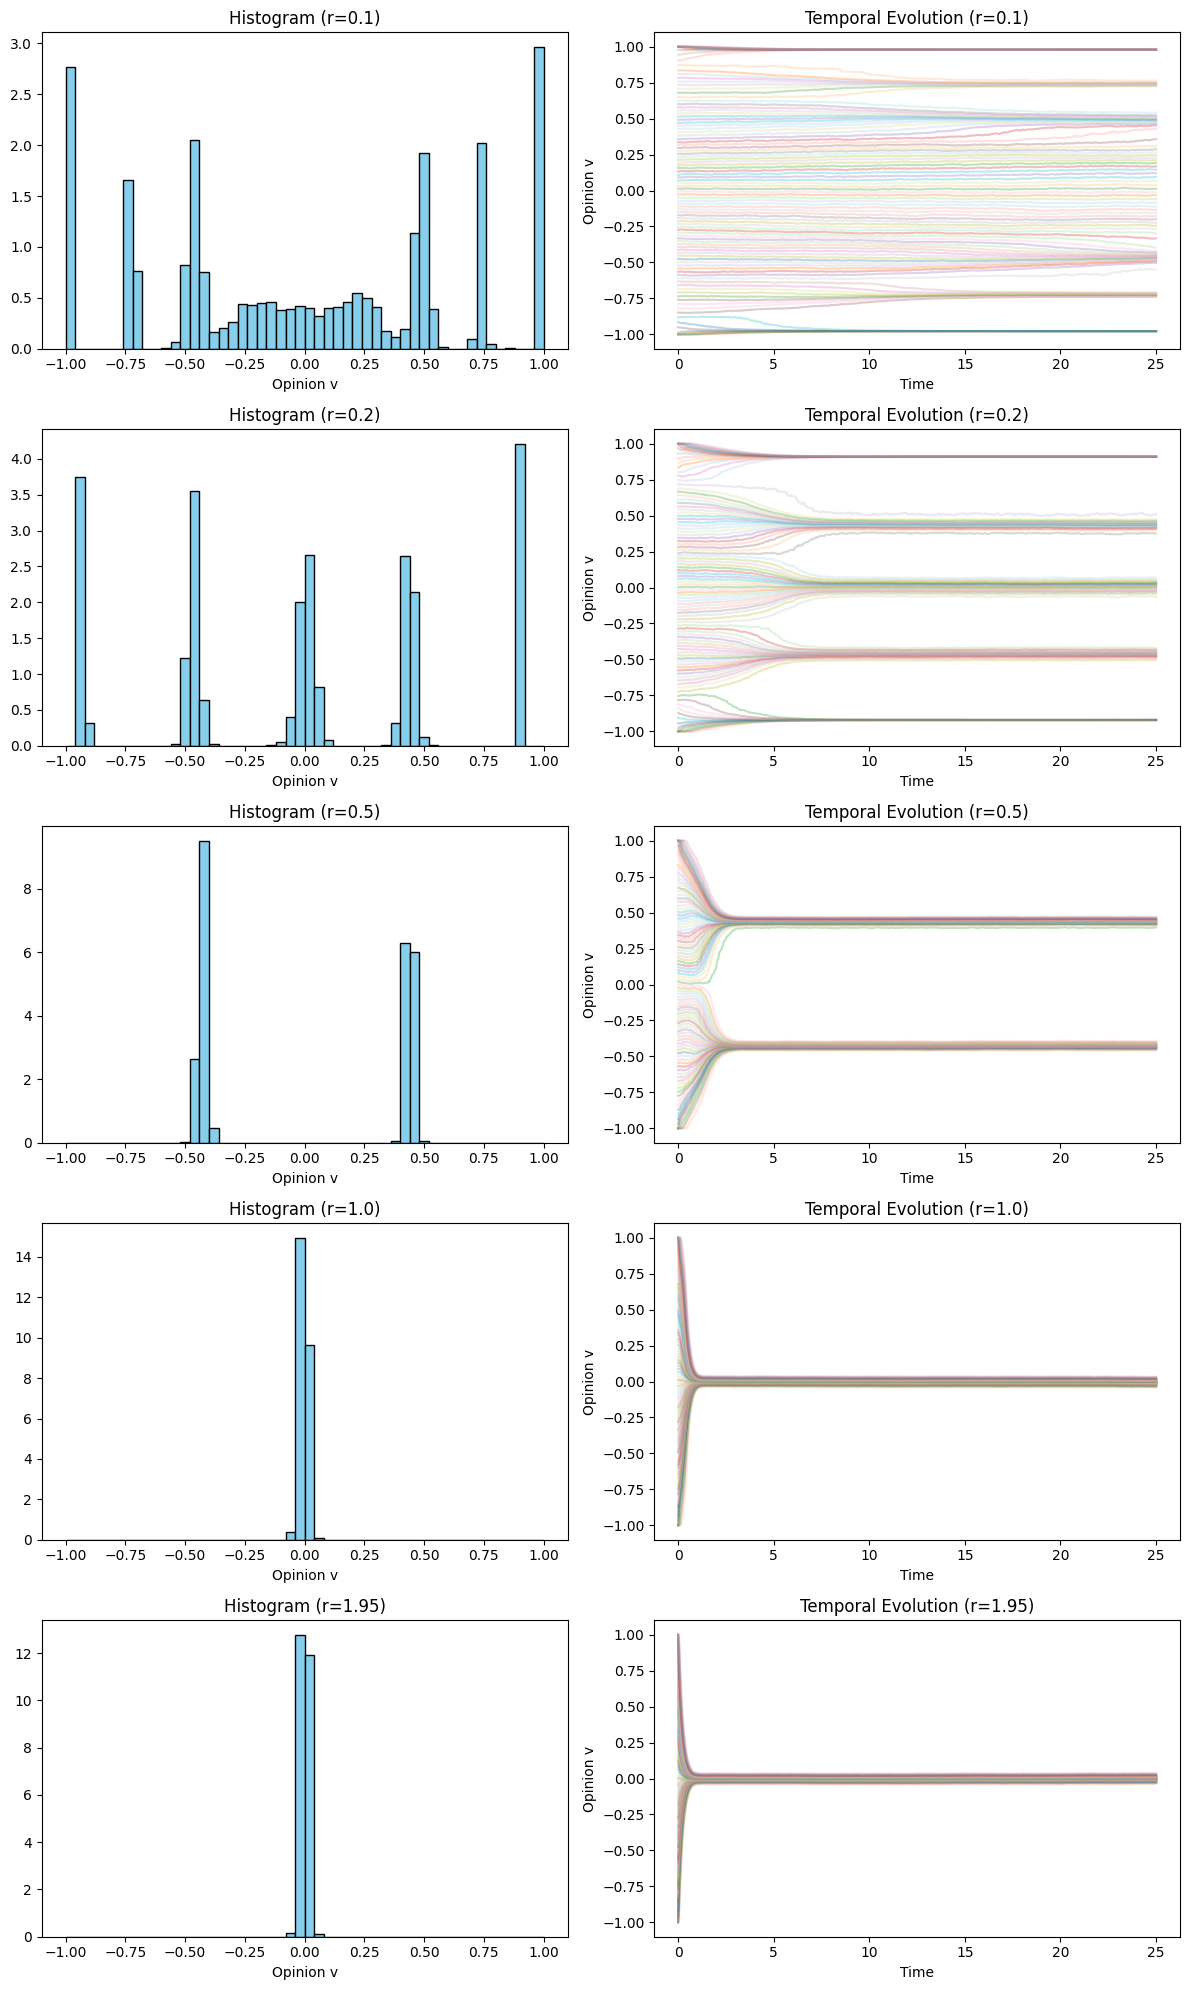

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Initial parameters of the model
N = 10000          # Number of agents
T_final = 25.0    # Final time
dt = 0.05          # Time step
n_steps = int(T_final / dt)

# Social parameters
gamma = 0.25      # Compromise parameter (we set 0.25, as the value has to be between 0 and 0.5)
sigma = 0.01      # Standard deviation of noise (eta)
alphav = 2.0       # Power of the diffusion function D(v)
r_tolerance = 0.5 # Confidence radius

# Auxiliar Functions

def P(dist, r):
    """Function of Bounded Confidence (Indicator function)"""
    # Returns 1 if the distance is less or equal than r, 0 otherwise
    return np.where(dist <= r, 1.0, 0.0)

def D(v, alpha):
    """Diffusion function"""
    # It makes changes near the boundaries more difficult
    return (1 - v**2)**alpha

def simulation_opinion(N, n_steps, dt, gamma, sigma, r, alphav, init_dist):
    # Initialize
    if init_dist == 'uniform':
        v = np.random.uniform(-1, 1.000001, N)
        v = np.clip(v, -1, 1)
    elif init_dist == 'normal':
        v = np.random.normal(0,1,N)
        v = np.clip(v, -1, 1)
    elif init_dist == 'bimodal':
        v = np.concatenate([
            np.random.normal(-0.5, 0.5, N//2),
            np.random.normal(0.5, 0.5, N//2)
        ])
        v = np.clip(v, -1, 1)

    #saving the trajectories of the opinions
    history = np.zeros((n_steps+1, N))
    history[0] = v
    # time loop
    for t in range(n_steps):
        # NB scheme.
        # Select N/2 random pairs.
        # We assume that for every time step, N/2 pairs are sampled.

        idx = np.random.permutation(N)
        i_idx = idx[:N//2]
        j_idx = idx[N//2:]

        vi = v[i_idx]
        vj = v[j_idx]

        # Opinion distance
        dist = np.abs(vi - vj)

        # Sampling noise (eta)
        # eta ~ Normal(0, sigma)
        eta1 = np.random.normal(0, sigma, size=N//2)
        eta2 = np.random.normal(0, sigma, size=N//2)

        # Compute P
        # P_val will be 1 if both agents interact, 0 otherwise
        P_val = P(dist, r)

        # Opinion update

        diff = vi - vj

        vi_new = vi - gamma * P_val * diff + eta1 * D(vi, alphav)
        vj_new = vj - gamma * P_val * (-diff) + eta2 * D(vj, alphav)

        # Projection operator (or 'clipping') in order to mantain opinions in [-1, 1]
        vi_new = np.clip(vi_new, -1, 1)
        vj_new = np.clip(vj_new, -1, 1)

        # Update opinions vector
        v[i_idx] = vi_new
        v[j_idx] = vj_new

        history[t+1] = v

    return history
#---------------------------------------------------------------------------#
# First experiment : Vary confidence radius 'r'; for uniform distribution
radii = [0.1, 0.2, 0.5, 1.0, 1.95]
time_axis = np.linspace(0, T_final, n_steps + 1)

fig, axes = plt.subplots(len(radii), 2, figsize=(12, 4 * len(radii)))

# 100 lines, representing percentiles from 1% to 99%
quantiles = np.linspace(1, 99, 100)

cmap = plt.get_cmap('tab20')
base_colors = [cmap(i) for i in np.linspace(0, 1, 20)]
colors = base_colors * 5  # Repeat 5 times to get 100 colors
np.random.seed(42)
np.random.shuffle(colors)

for i, r in enumerate(radii):
    history = simulation_opinion(N, n_steps, dt, gamma, sigma, r, alphav, init_dist='uniform')
    final_opinions = history[-1]

    # Histogram
    axes[i, 0].hist(final_opinions, bins=50, range=(-1, 1), density=True,  color='skyblue', edgecolor='black')
    axes[i, 0].set_title(f"Histogram (r={r})")
    axes[i, 0].set_xlabel("Opinion v")
    axes[i, 0].set_xlim(-1.1, 1.1)

    # Temporal trajectories
    quantile_history = np.percentile(history, quantiles, axis=1)

    for q_idx in range(len(quantiles)):
        axes[i, 1].plot(time_axis, quantile_history[q_idx, :],
                        color=colors[q_idx], alpha=0.3, linewidth=1.5)

    axes[i, 1].set_title(f"Temporal Evolution (r={r})")
    axes[i, 1].set_xlabel("Time")
    axes[i, 1].set_ylabel("Opinion v")
    axes[i, 1].set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.savefig(f"Opinions_r_uniform.png")
plt.show()

#--------------------------------------------------------------------------#
# First experiment : Vary confidence radius 'r'; for normal distribution
radii = [0.1, 0.2, 0.5, 1.0, 1.95]
time_axis = np.linspace(0, T_final, n_steps + 1)

fig, axes = plt.subplots(len(radii), 2, figsize=(12, 4 * len(radii)))

# 100 lines, representing percentiles from 1% to 99%
quantiles = np.linspace(1, 99, 100)

cmap = plt.get_cmap('tab20')
base_colors = [cmap(i) for i in np.linspace(0, 1, 20)]
colors = base_colors * 5  # Repeat 5 times to get 100 colors
np.random.seed(42)
np.random.shuffle(colors)

for i, r in enumerate(radii):
    history = simulation_opinion(N, n_steps, dt, gamma, sigma, r, alphav, init_dist='normal')
    final_opinions = history[-1]

    # Histogram
    axes[i, 0].hist(final_opinions, bins=50, range=(-1, 1), density=True,  color='skyblue', edgecolor='black')
    axes[i, 0].set_title(f"Histogram (r={r})")
    axes[i, 0].set_xlabel("Opinion v")
    axes[i, 0].set_xlim(-1.1, 1.1)

    # Temporal trajectories
    quantile_history = np.percentile(history, quantiles, axis=1)

    for q_idx in range(len(quantiles)):
        axes[i, 1].plot(time_axis, quantile_history[q_idx, :],
                        color=colors[q_idx], alpha=0.3, linewidth=1.5)

    axes[i, 1].set_title(f"Temporal Evolution (r={r})")
    axes[i, 1].set_xlabel("Time")
    axes[i, 1].set_ylabel("Opinion v")
    axes[i, 1].set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.savefig(f"Opinions_r_normal.png")
plt.show()

#--------------------------------------------------------------------------#
# First experiment : Vary confidence radius 'r'; ; for bimodal distribution
radii = [0.1, 0.2, 0.5, 1.0, 1.95]
time_axis = np.linspace(0, T_final, n_steps + 1)

fig, axes = plt.subplots(len(radii), 2, figsize=(12, 4 * len(radii)))

# 100 lines, representing percentiles from 1% to 99%
quantiles = np.linspace(1, 99, 100)

cmap = plt.get_cmap('tab20')
base_colors = [cmap(i) for i in np.linspace(0, 1, 20)]
colors = base_colors * 5  # Repeat 5 times to get 100 colors
np.random.seed(42)
np.random.shuffle(colors)

for i, r in enumerate(radii):
    history = simulation_opinion(N, n_steps, dt, gamma, sigma, r, alphav, init_dist='bimodal')
    final_opinions = history[-1]

    # Histogram
    axes[i, 0].hist(final_opinions, bins=50, range=(-1, 1), density=True,  color='skyblue', edgecolor='black')
    axes[i, 0].set_title(f"Histogram (r={r})")
    axes[i, 0].set_xlabel("Opinion v")
    axes[i, 0].set_xlim(-1.1, 1.1)

    # Temporal trajectories
    quantile_history = np.percentile(history, quantiles, axis=1)

    for q_idx in range(len(quantiles)):
        axes[i, 1].plot(time_axis, quantile_history[q_idx, :],
                        color=colors[q_idx], alpha=0.3, linewidth=1.5)

    axes[i, 1].set_title(f"Temporal Evolution (r={r})")
    axes[i, 1].set_xlabel("Time")
    axes[i, 1].set_ylabel("Opinion v")
    axes[i, 1].set_ylim(-1.1, 1.1)


plt.tight_layout()
plt.savefig(f"Opinions_r_bimodal.png")
plt.show()

<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:67: SyntaxWarning: invalid escape sequence '\s'
<>:78: SyntaxWarning: invalid escape sequence '\s'
<>:110: SyntaxWarning: invalid escape sequence '\s'
<>:121: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:67: SyntaxWarning: invalid escape sequence '\s'
<>:78: SyntaxWarning: invalid escape sequence '\s'
<>:110: SyntaxWarning: invalid escape sequence '\s'
<>:121: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3078583686.py:24: SyntaxWarning: invalid escape sequence '\s'
  axes[i, 0].set_title(f"Histogram (Noise $\sigma={s}$)")
/tmp/ipython-input-3078583686.py:35: SyntaxWarning: invalid escape sequence '\s'
  axes[i, 1].set_title(f"Temporal Evolution (Noise $\sigma={s}$)")
/tmp/ipython-input-3078583686.py:67: SyntaxWarning: invalid escape sequence '\s'
  axes[i, 0].set

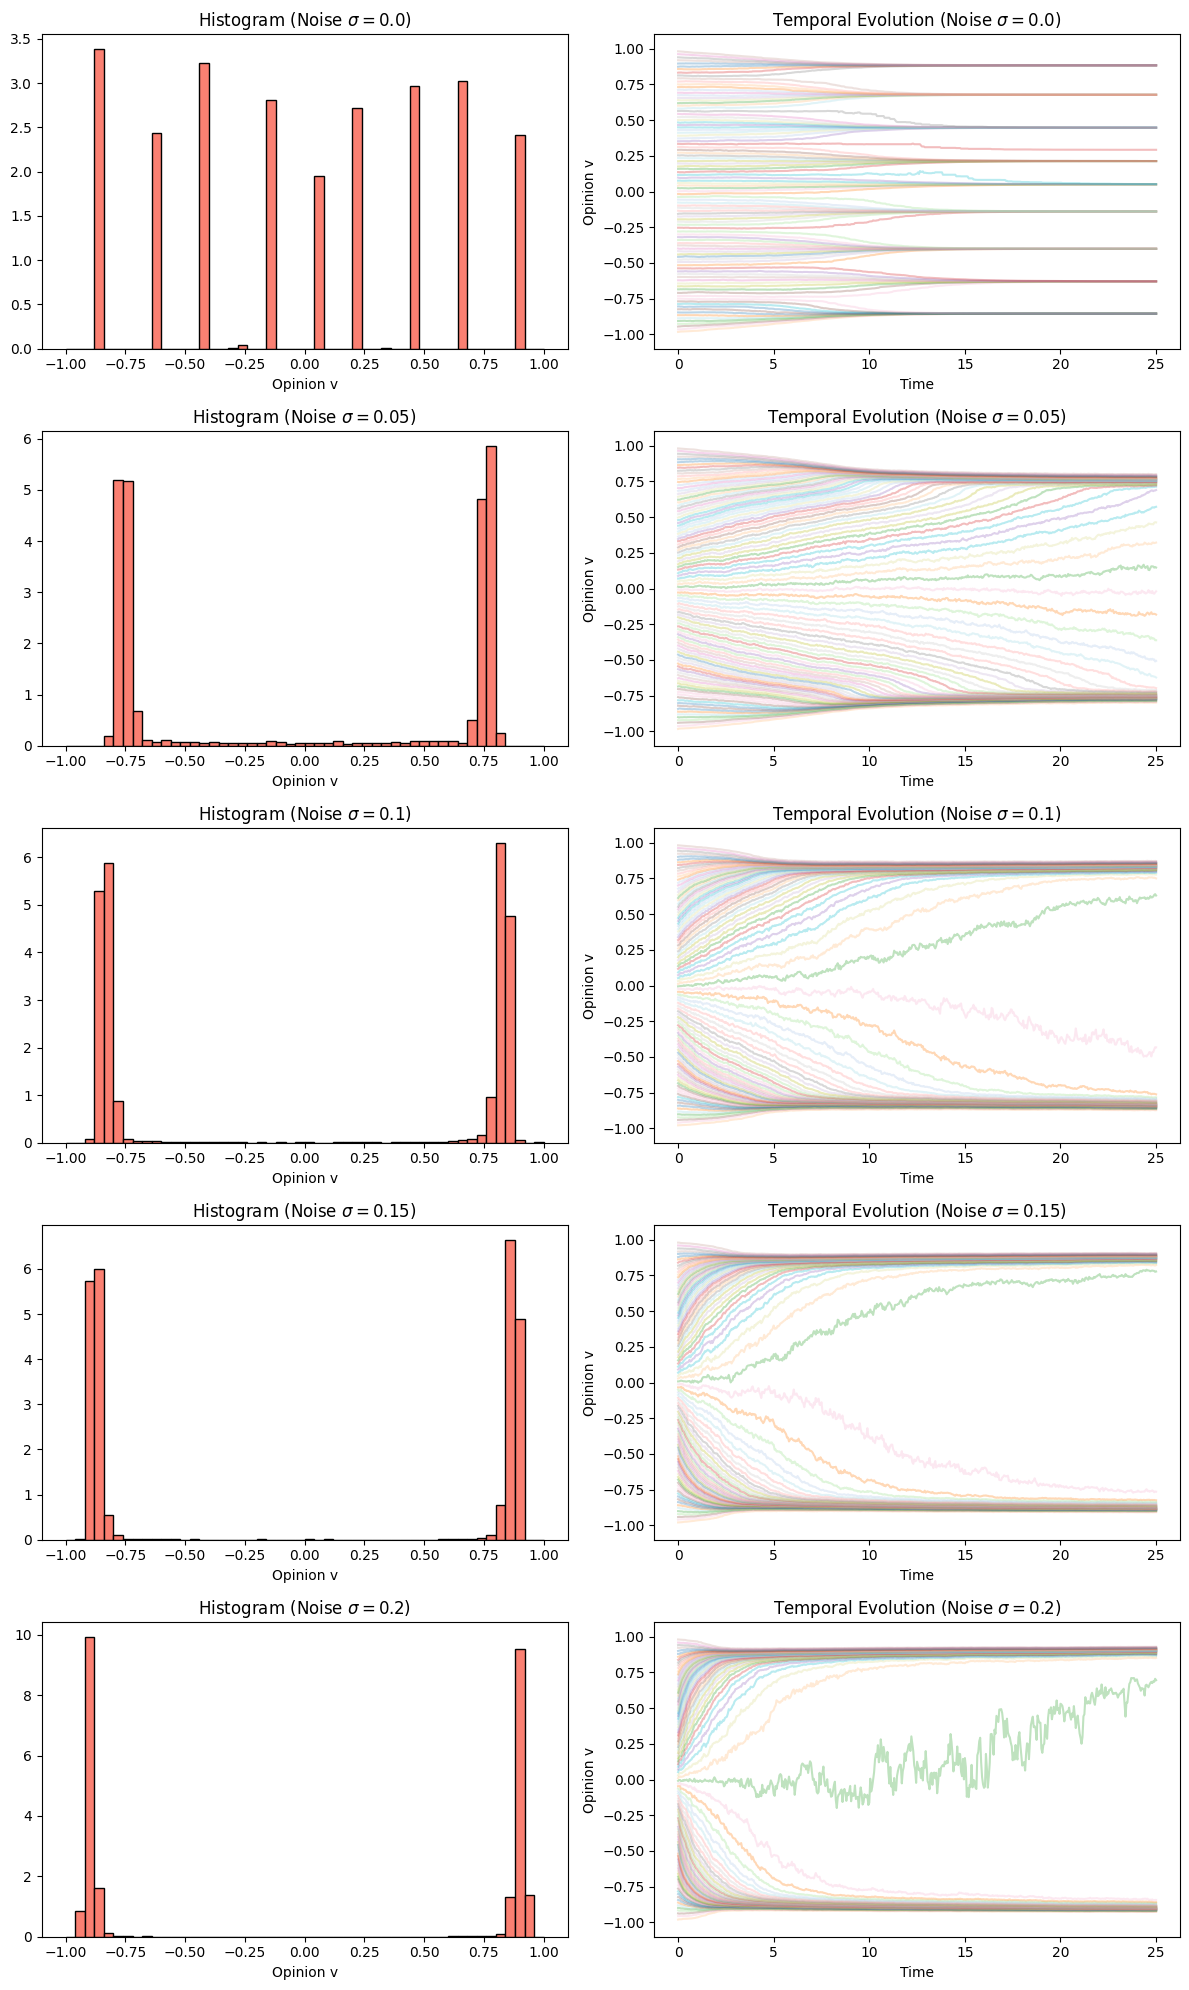

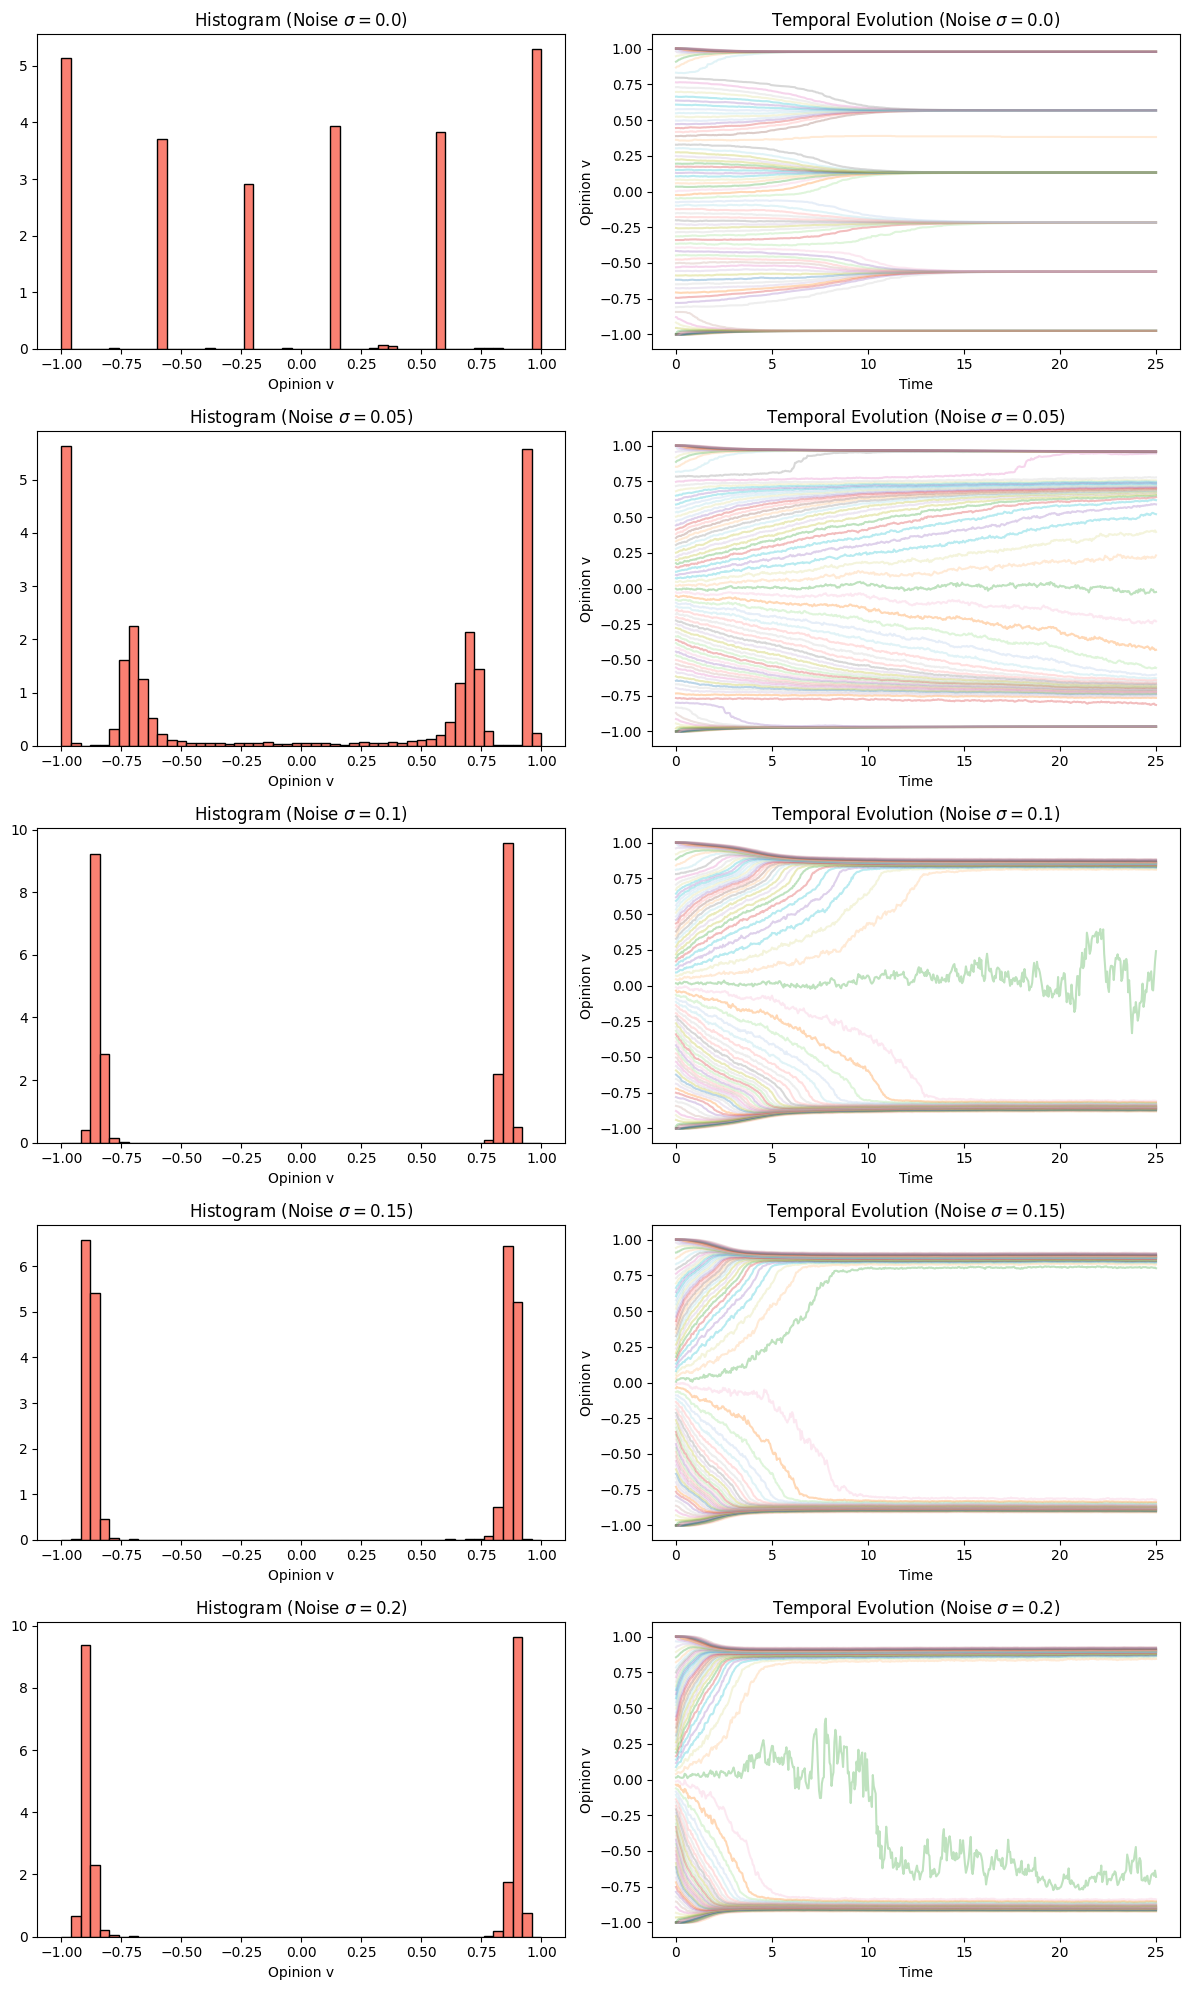

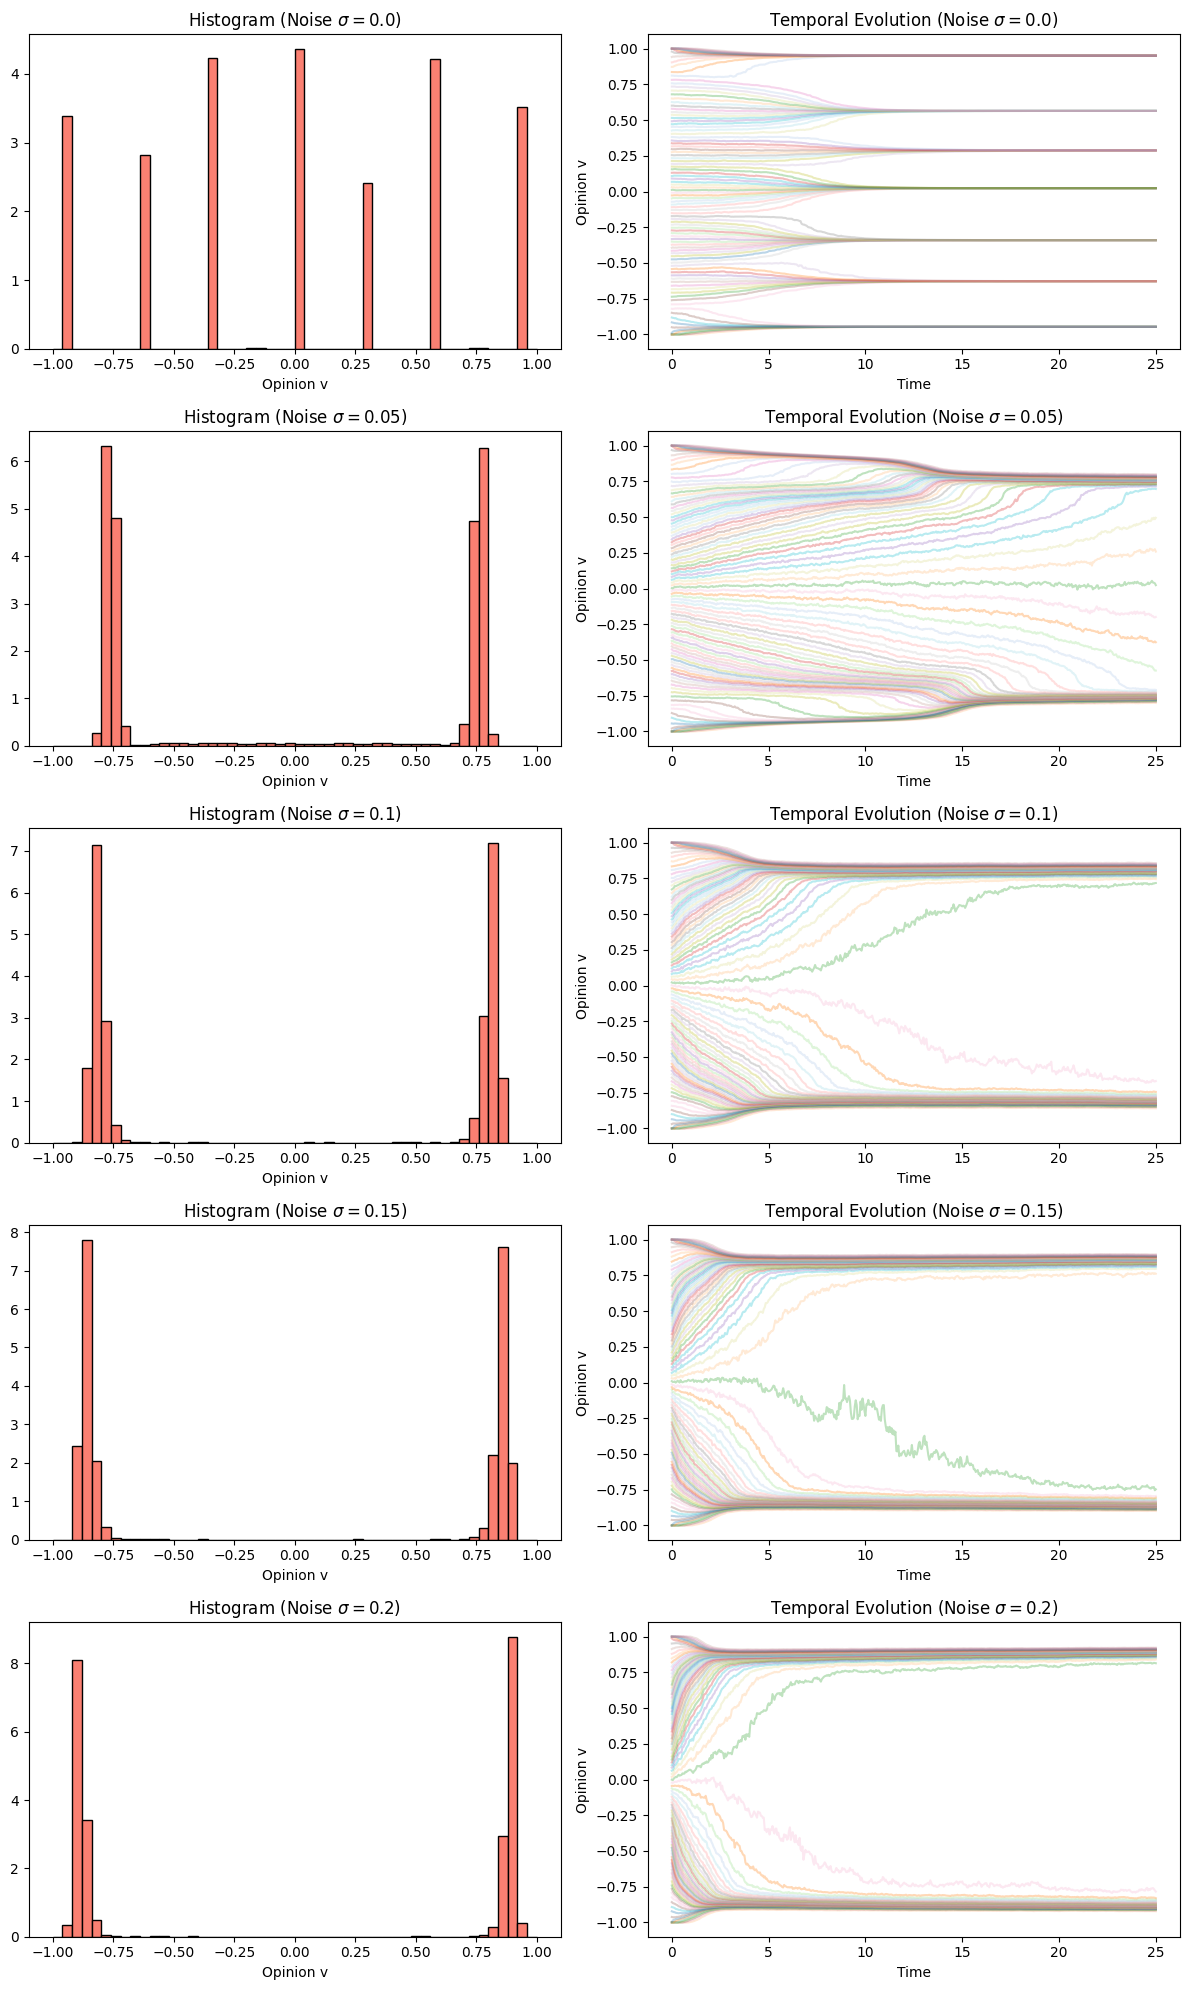

In [ ]:
# Second experiment: Varying noise (Diffusion)

sigmas = [0.0, 0.05, 0.1, 0.15, 0.2]
r_fixed = 0.1 # High radius to favor consensus
time_axis = np.linspace(0, T_final, n_steps + 1)

fig, axes = plt.subplots(len(radii), 2, figsize=(12, 4 * len(radii)))

# 100 lines, representing percentiles from 1% to 99%
quantiles = np.linspace(1, 99, 100)

cmap = plt.get_cmap('tab20')
base_colors = [cmap(i) for i in np.linspace(0, 1, 20)]
colors = base_colors * 5  # Repeat 5 times to get 100 colors
np.random.seed(42)
np.random.shuffle(colors)

for i, s in enumerate(sigmas):
    history = simulation_opinion(N, n_steps, dt, gamma, s, r_fixed, alphav, init_dist='uniform')
    final_opinions = history[-1]

    # Histogram
    axes[i, 0].hist(final_opinions, bins=50, range=(-1, 1), density=True,  color='salmon', edgecolor='black')
    axes[i, 0].set_title(f"Histogram (Noise $\sigma={s}$)")
    axes[i, 0].set_xlabel("Opinion v")
    axes[i, 0].set_xlim(-1.1, 1.1)

    # Temporal trajectories
    quantile_history = np.percentile(history, quantiles, axis=1)

    for q_idx in range(len(quantiles)):
        axes[i, 1].plot(time_axis, quantile_history[q_idx, :],
                        color=colors[q_idx], alpha=0.3, linewidth=1.5)

    axes[i, 1].set_title(f"Temporal Evolution (Noise $\sigma={s}$)")
    axes[i, 1].set_xlabel("Time")
    axes[i, 1].set_ylabel("Opinion v")
    axes[i, 1].set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.savefig(f"Opinions_s_uniform_015.png")
plt.show()

# Second experiment: Varying noise (Diffusion)

sigmas = [0.0, 0.05, 0.1, 0.15, 0.2]
r_fixed = 0.15 # High radius to favor consensus
time_axis = np.linspace(0, T_final, n_steps + 1)

fig, axes = plt.subplots(len(radii), 2, figsize=(12, 4 * len(radii)))

# 100 lines, representing percentiles from 1% to 99%
quantiles = np.linspace(1, 99, 100)

cmap = plt.get_cmap('tab20')
base_colors = [cmap(i) for i in np.linspace(0, 1, 20)]
colors = base_colors * 5  # Repeat 5 times to get 100 colors
np.random.seed(42)
np.random.shuffle(colors)

for i, s in enumerate(sigmas):
    history = simulation_opinion(N, n_steps, dt, gamma, s, r_fixed, alphav, init_dist='normal')
    final_opinions = history[-1]

    # Histogram
    axes[i, 0].hist(final_opinions, bins=50, range=(-1, 1), density=True,  color='salmon', edgecolor='black')
    axes[i, 0].set_title(f"Histogram (Noise $\sigma={s}$)")
    axes[i, 0].set_xlabel("Opinion v")
    axes[i, 0].set_xlim(-1.1, 1.1)

    # Temporal trajectories
    quantile_history = np.percentile(history, quantiles, axis=1)

    for q_idx in range(len(quantiles)):
        axes[i, 1].plot(time_axis, quantile_history[q_idx, :],
                        color=colors[q_idx], alpha=0.3, linewidth=1.5)

    axes[i, 1].set_title(f"Temporal Evolution (Noise $\sigma={s}$)")
    axes[i, 1].set_xlabel("Time")
    axes[i, 1].set_ylabel("Opinion v")
    axes[i, 1].set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.savefig(f"Opinions_s_normal_015.png")
plt.show()

# Second experiment: Varying noise (Diffusion)

sigmas = [0.0, 0.05, 0.1, 0.15, 0.2]
r_fixed = 0.15 # High radius to favor consensus
time_axis = np.linspace(0, T_final, n_steps + 1)

fig, axes = plt.subplots(len(radii), 2, figsize=(12, 4 * len(radii)))

# 100 lines, representing percentiles from 1% to 99%
quantiles = np.linspace(1, 99, 100)

cmap = plt.get_cmap('tab20')
base_colors = [cmap(i) for i in np.linspace(0, 1, 20)]
colors = base_colors * 5  # Repeat 5 times to get 100 colors
np.random.seed(42)
np.random.shuffle(colors)

for i, s in enumerate(sigmas):
    history = simulation_opinion(N, n_steps, dt, gamma, s, r_fixed, alphav, init_dist='bimodal')
    final_opinions = history[-1]

    # Histogram
    axes[i, 0].hist(final_opinions, bins=50, range=(-1, 1), density=True,  color='salmon', edgecolor='black')
    axes[i, 0].set_title(f"Histogram (Noise $\sigma={s}$)")
    axes[i, 0].set_xlabel("Opinion v")
    axes[i, 0].set_xlim(-1.1, 1.1)

    # Temporal trajectories
    quantile_history = np.percentile(history, quantiles, axis=1)

    for q_idx in range(len(quantiles)):
        axes[i, 1].plot(time_axis, quantile_history[q_idx, :],
                        color=colors[q_idx], alpha=0.3, linewidth=1.5)

    axes[i, 1].set_title(f"Temporal Evolution (Noise $\sigma={s}$)")
    axes[i, 1].set_xlabel("Time")
    axes[i, 1].set_ylabel("Opinion v")
    axes[i, 1].set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.savefig(f"Opinions_s_bimodal_015.png")
plt.show()



<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:67: SyntaxWarning: invalid escape sequence '\s'
<>:78: SyntaxWarning: invalid escape sequence '\s'
<>:110: SyntaxWarning: invalid escape sequence '\s'
<>:121: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:67: SyntaxWarning: invalid escape sequence '\s'
<>:78: SyntaxWarning: invalid escape sequence '\s'
<>:110: SyntaxWarning: invalid escape sequence '\s'
<>:121: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-444743553.py:24: SyntaxWarning: invalid escape sequence '\s'
  axes[i, 0].set_title(f"Histogram (Noise $\sigma={s}$)")
/tmp/ipython-input-444743553.py:35: SyntaxWarning: invalid escape sequence '\s'
  axes[i, 1].set_title(f"Temporal Evolution (Noise $\sigma={s}$)")
/tmp/ipython-input-444743553.py:67: SyntaxWarning: invalid escape sequence '\s'
  axes[i, 0].set_ti

KeyboardInterrupt: 

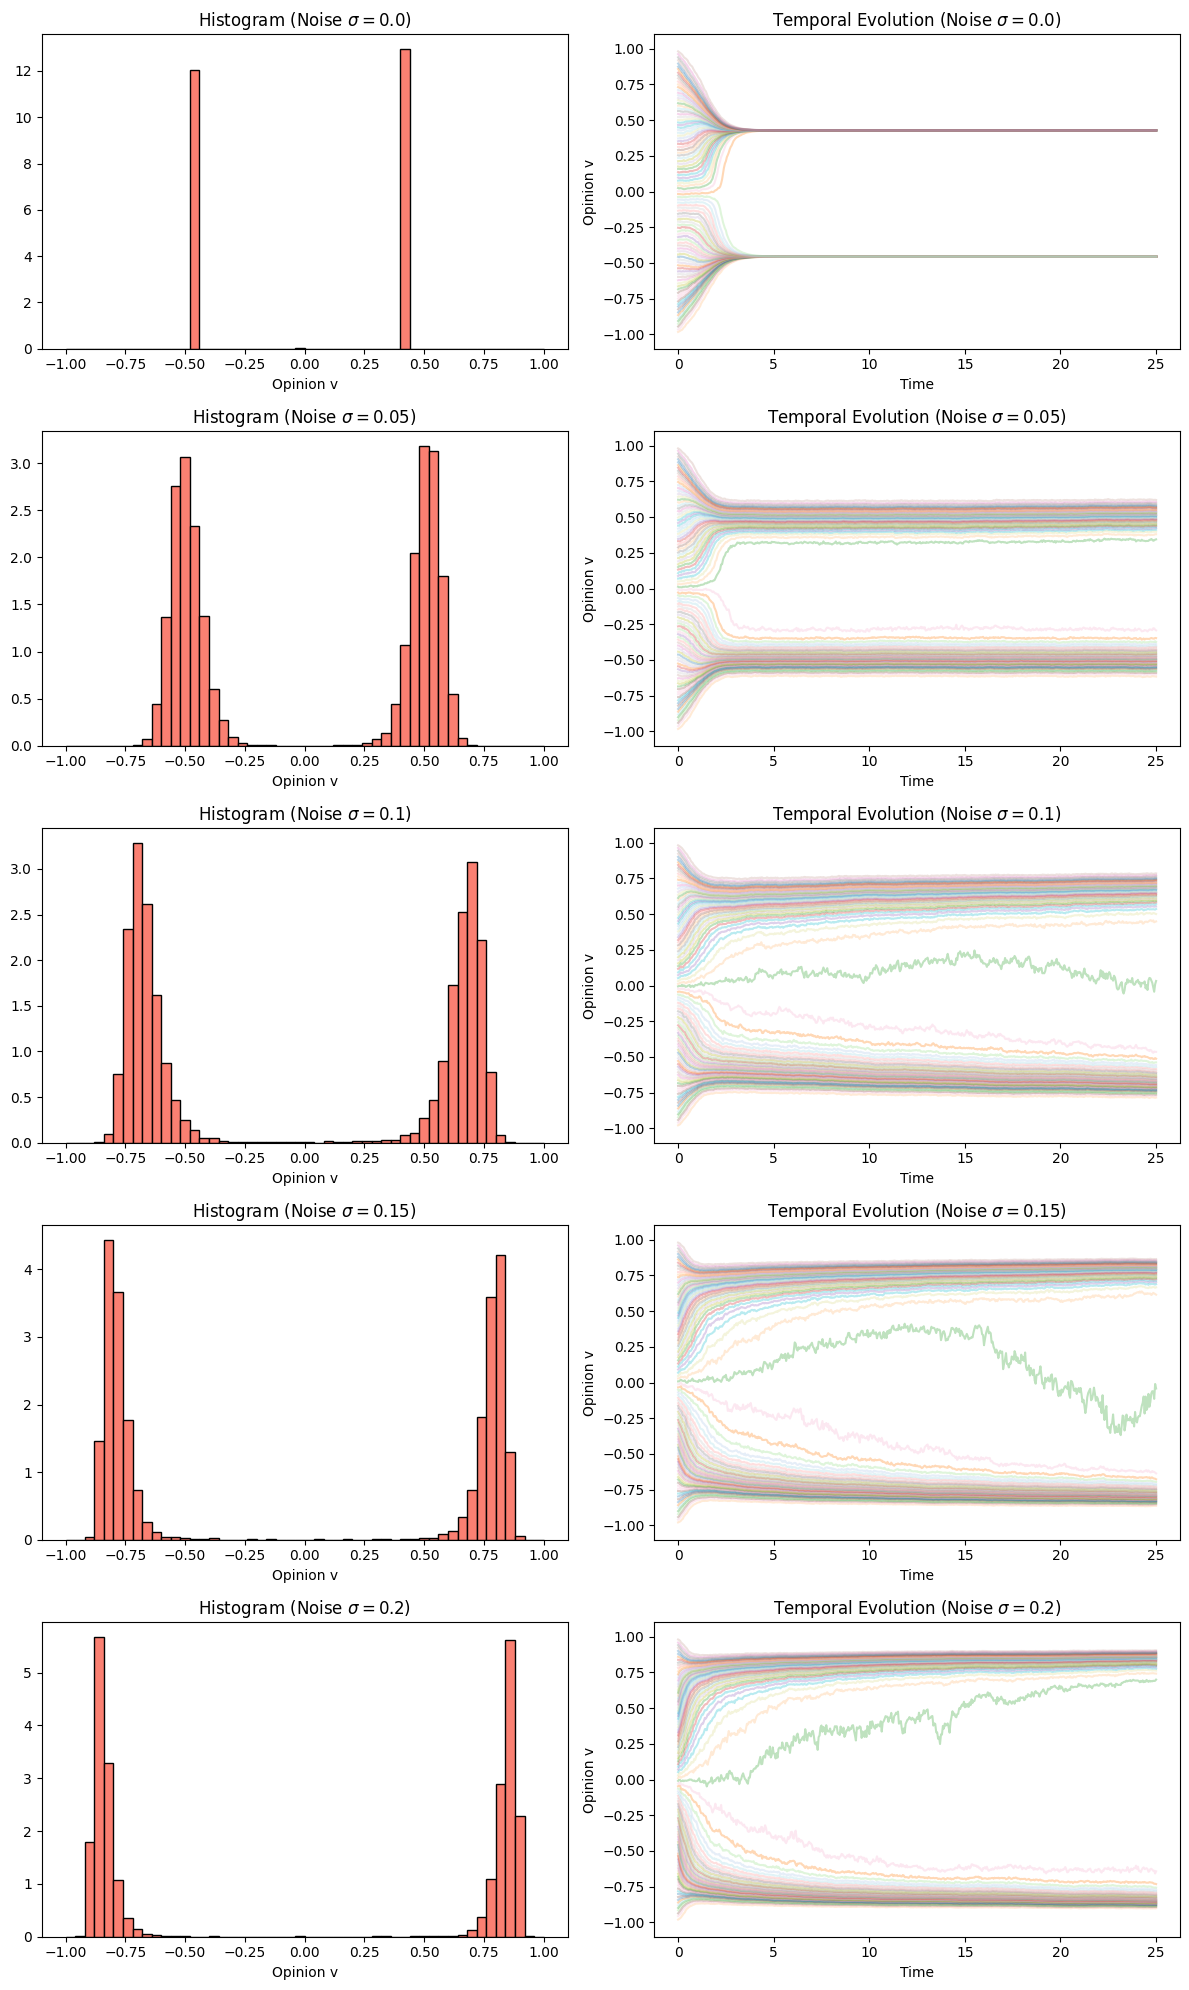

In [ ]:
# Second experiment: Varying noise (Diffusion)

sigmas = [0.0, 0.05, 0.1, 0.15, 0.2]
r_fixed = 0.4 # High radius to favor consensus
time_axis = np.linspace(0, T_final, n_steps + 1)

fig, axes = plt.subplots(len(radii), 2, figsize=(12, 4 * len(radii)))

# 100 lines, representing percentiles from 1% to 99%
quantiles = np.linspace(1, 99, 100)

cmap = plt.get_cmap('tab20')
base_colors = [cmap(i) for i in np.linspace(0, 1, 20)]
colors = base_colors * 5  # Repeat 5 times to get 100 colors
np.random.seed(42)
np.random.shuffle(colors)

for i, s in enumerate(sigmas):
    history = simulation_opinion(N, n_steps, dt, gamma, s, r_fixed, alphav, init_dist='uniform')
    final_opinions = history[-1]

    # Histogram
    axes[i, 0].hist(final_opinions, bins=50, range=(-1, 1), density=True,  color='salmon', edgecolor='black')
    axes[i, 0].set_title(f"Histogram (Noise $\sigma={s}$)")
    axes[i, 0].set_xlabel("Opinion v")
    axes[i, 0].set_xlim(-1.1, 1.1)

    # Temporal trajectories
    quantile_history = np.percentile(history, quantiles, axis=1)

    for q_idx in range(len(quantiles)):
        axes[i, 1].plot(time_axis, quantile_history[q_idx, :],
                        color=colors[q_idx], alpha=0.3, linewidth=1.5)

    axes[i, 1].set_title(f"Temporal Evolution (Noise $\sigma={s}$)")
    axes[i, 1].set_xlabel("Time")
    axes[i, 1].set_ylabel("Opinion v")
    axes[i, 1].set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.savefig(f"Opinions_s_uniform_04.png")
plt.show()

# Second experiment: Varying noise (Diffusion)

sigmas = [0.0, 0.05, 0.1, 0.15, 0.2]
r_fixed = 0.4 # High radius to favor consensus
time_axis = np.linspace(0, T_final, n_steps + 1)

fig, axes = plt.subplots(len(radii), 2, figsize=(12, 4 * len(radii)))

# 100 lines, representing percentiles from 1% to 99%
quantiles = np.linspace(1, 99, 100)

cmap = plt.get_cmap('tab20')
base_colors = [cmap(i) for i in np.linspace(0, 1, 20)]
colors = base_colors * 5  # Repeat 5 times to get 100 colors
np.random.seed(42)
np.random.shuffle(colors)

for i, s in enumerate(sigmas):
    history = simulation_opinion(N, n_steps, dt, gamma, s, r_fixed, alphav, init_dist='normal')
    final_opinions = history[-1]

    # Histogram
    axes[i, 0].hist(final_opinions, bins=50, range=(-1, 1), density=True,  color='salmon', edgecolor='black')
    axes[i, 0].set_title(f"Histogram (Noise $\sigma={s}$)")
    axes[i, 0].set_xlabel("Opinion v")
    axes[i, 0].set_xlim(-1.1, 1.1)

    # Temporal trajectories
    quantile_history = np.percentile(history, quantiles, axis=1)

    for q_idx in range(len(quantiles)):
        axes[i, 1].plot(time_axis, quantile_history[q_idx, :],
                        color=colors[q_idx], alpha=0.3, linewidth=1.5)

    axes[i, 1].set_title(f"Temporal Evolution (Noise $\sigma={s}$)")
    axes[i, 1].set_xlabel("Time")
    axes[i, 1].set_ylabel("Opinion v")
    axes[i, 1].set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.savefig(f"Opinions_s_normal_04.png")
plt.show()

# Second experiment: Varying noise (Diffusion)

sigmas = [0.0, 0.05, 0.1, 0.15, 0.2]
r_fixed = 0.4 # High radius to favor consensus
time_axis = np.linspace(0, T_final, n_steps + 1)

fig, axes = plt.subplots(len(radii), 2, figsize=(12, 4 * len(radii)))

# 100 lines, representing percentiles from 1% to 99%
quantiles = np.linspace(1, 99, 100)

cmap = plt.get_cmap('tab20')
base_colors = [cmap(i) for i in np.linspace(0, 1, 20)]
colors = base_colors * 5  # Repeat 5 times to get 100 colors
np.random.seed(42)
np.random.shuffle(colors)

for i, s in enumerate(sigmas):
    history = simulation_opinion(N, n_steps, dt, gamma, s, r_fixed, alphav, init_dist='bimodal')
    final_opinions = history[-1]

    # Histogram
    axes[i, 0].hist(final_opinions, bins=50, range=(-1, 1), density=True,  color='salmon', edgecolor='black')
    axes[i, 0].set_title(f"Histogram (Noise $\sigma={s}$)")
    axes[i, 0].set_xlabel("Opinion v")
    axes[i, 0].set_xlim(-1.1, 1.1)

    # Temporal trajectories
    quantile_history = np.percentile(history, quantiles, axis=1)

    for q_idx in range(len(quantiles)):
        axes[i, 1].plot(time_axis, quantile_history[q_idx, :],
                        color=colors[q_idx], alpha=0.3, linewidth=1.5)

    axes[i, 1].set_title(f"Temporal Evolution (Noise $\sigma={s}$)")
    axes[i, 1].set_xlabel("Time")
    axes[i, 1].set_ylabel("Opinion v")
    axes[i, 1].set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.savefig(f"Opinions_s_bimodal_04.png")
plt.show()



In [ ]:
# Second experiment: Varying noise (Diffusion)

sigmas = [0.0, 0.05, 0.1, 0.15, 0.2]
r_fixed = 0.8 # High radius to favor consensus
time_axis = np.linspace(0, T_final, n_steps + 1)

fig, axes = plt.subplots(len(radii), 2, figsize=(12, 4 * len(radii)))

# 100 lines, representing percentiles from 1% to 99%
quantiles = np.linspace(1, 99, 100)

cmap = plt.get_cmap('tab20')
base_colors = [cmap(i) for i in np.linspace(0, 1, 20)]
colors = base_colors * 5  # Repeat 5 times to get 100 colors
np.random.seed(42)
np.random.shuffle(colors)

for i, s in enumerate(sigmas):
    history = simulation_opinion(N, n_steps, dt, gamma, s, r_fixed, alphav, init_dist='uniform')
    final_opinions = history[-1]

    # Histogram
    axes[i, 0].hist(final_opinions, bins=50, range=(-1, 1), density=True,  color='salmon', edgecolor='black')
    axes[i, 0].set_title(f"Histogram (Noise $\sigma={s}$)")
    axes[i, 0].set_xlabel("Opinion v")
    axes[i, 0].set_xlim(-1.1, 1.1)

    # Temporal trajectories
    quantile_history = np.percentile(history, quantiles, axis=1)

    for q_idx in range(len(quantiles)):
        axes[i, 1].plot(time_axis, quantile_history[q_idx, :],
                        color=colors[q_idx], alpha=0.3, linewidth=1.5)

    axes[i, 1].set_title(f"Temporal Evolution (Noise $\sigma={s}$)")
    axes[i, 1].set_xlabel("Time")
    axes[i, 1].set_ylabel("Opinion v")
    axes[i, 1].set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.savefig(f"Opinions_s_uniform_08.png")
plt.show()

# Second experiment: Varying noise (Diffusion)

sigmas = [0.0, 0.05, 0.1, 0.15, 0.2]
r_fixed = 0.8 # High radius to favor consensus
time_axis = np.linspace(0, T_final, n_steps + 1)

fig, axes = plt.subplots(len(radii), 2, figsize=(12, 4 * len(radii)))

# 100 lines, representing percentiles from 1% to 99%
quantiles = np.linspace(1, 99, 100)

cmap = plt.get_cmap('tab20')
base_colors = [cmap(i) for i in np.linspace(0, 1, 20)]
colors = base_colors * 5  # Repeat 5 times to get 100 colors
np.random.seed(42)
np.random.shuffle(colors)

for i, s in enumerate(sigmas):
    history = simulation_opinion(N, n_steps, dt, gamma, s, r_fixed, alphav, init_dist='normal')
    final_opinions = history[-1]

    # Histogram
    axes[i, 0].hist(final_opinions, bins=50, range=(-1, 1), density=True,  color='salmon', edgecolor='black')
    axes[i, 0].set_title(f"Histogram (Noise $\sigma={s}$)")
    axes[i, 0].set_xlabel("Opinion v")
    axes[i, 0].set_xlim(-1.1, 1.1)

    # Temporal trajectories
    quantile_history = np.percentile(history, quantiles, axis=1)

    for q_idx in range(len(quantiles)):
        axes[i, 1].plot(time_axis, quantile_history[q_idx, :],
                        color=colors[q_idx], alpha=0.3, linewidth=1.5)

    axes[i, 1].set_title(f"Temporal Evolution (Noise $\sigma={s}$)")
    axes[i, 1].set_xlabel("Time")
    axes[i, 1].set_ylabel("Opinion v")
    axes[i, 1].set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.savefig(f"Opinions_s_normal_08.png")
plt.show()

# Second experiment: Varying noise (Diffusion)

sigmas = [0.0, 0.05, 0.1, 0.15, 0.2]
r_fixed = 0.8 # High radius to favor consensus
time_axis = np.linspace(0, T_final, n_steps + 1)

fig, axes = plt.subplots(len(radii), 2, figsize=(12, 4 * len(radii)))

# 100 lines, representing percentiles from 1% to 99%
quantiles = np.linspace(1, 99, 100)

cmap = plt.get_cmap('tab20')
base_colors = [cmap(i) for i in np.linspace(0, 1, 20)]
colors = base_colors * 5  # Repeat 5 times to get 100 colors
np.random.seed(42)
np.random.shuffle(colors)

for i, s in enumerate(sigmas):
    history = simulation_opinion(N, n_steps, dt, gamma, s, r_fixed, alphav, init_dist='bimodal')
    final_opinions = history[-1]

    # Histogram
    axes[i, 0].hist(final_opinions, bins=50, range=(-1, 1), density=True,  color='salmon', edgecolor='black')
    axes[i, 0].set_title(f"Histogram (Noise $\sigma={s}$)")
    axes[i, 0].set_xlabel("Opinion v")
    axes[i, 0].set_xlim(-1.1, 1.1)

    # Temporal trajectories
    quantile_history = np.percentile(history, quantiles, axis=1)

    for q_idx in range(len(quantiles)):
        axes[i, 1].plot(time_axis, quantile_history[q_idx, :],
                        color=colors[q_idx], alpha=0.3, linewidth=1.5)

    axes[i, 1].set_title(f"Temporal Evolution (Noise $\sigma={s}$)")
    axes[i, 1].set_xlabel("Time")
    axes[i, 1].set_ylabel("Opinion v")
    axes[i, 1].set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.savefig(f"Opinions_s_bimodal_08.png")
plt.show()



In [ ]:

# 2. Phase transition Heatmap  (Polarization vs Consensus)

# Defining the range of parameters
r_values = np.linspace(0.01, 0.6, 100)   # Radius threshold
sigma_values = np.linspace(0.0, 0.2, 100) # Noise

# Matrix to store the final results
phase_matrix = np.zeros((len(sigma_values), len(r_values)))

for i, s in enumerate(sigma_values):
  print("loop finalized")
  for j, r in enumerate(r_values):
      v_final = simulation_opinion(N, n_steps, dt, gamma, sigma, r, alphav, init_dist='uniform')

      phase_matrix[i, j] = np.var(v_final)

# Plot Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(phase_matrix, origin='lower', aspect='auto', cmap='viridis_r',
           extent=[r_values.min(), r_values.max(), sigma_values.min(), sigma_values.max()])

plt.colorbar(label="Final variance (0=Consensus, Alto=Polarization)")
plt.xlabel("Confidence Radius ($r$)")
plt.ylabel("Noise Intensity ($\sigma$)")
plt.title("Phase Transition Diagram: Consensus vs. Polarization")
plt.grid(False)
plt.savefig(f"Opinions_Heatmap_uniform.png")
plt.show()

In [ ]:

# 2. Phase transition Heatmap  (Polarization vs Consensus)

# Defining the range of parameters
r_values = np.linspace(0.01, 0.6, 100)   # Radius threshold
sigma_values = np.linspace(0.0, 0.2, 100) # Noise

# Matrix to store the final results
phase_matrix = np.zeros((len(sigma_values), len(r_values)))

for i, s in enumerate(sigma_values):
    for j, r in enumerate(r_values):
        v_final = simulation_opinion(N, n_steps, dt, gamma, sigma, r, alphav, init_dist='normal')

        phase_matrix[i, j] = np.var(v_final)

# Plot Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(phase_matrix, origin='lower', aspect='auto', cmap='viridis_r',
           extent=[r_values.min(), r_values.max(), sigma_values.min(), sigma_values.max()])

plt.colorbar(label="Final variance (0=Consensus, Alto=Polarization)")
plt.xlabel("Confidence Radius ($r$)")
plt.ylabel("Noise Intensity ($\sigma$)")
plt.title("Phase Transition Diagram: Consensus vs. Polarization")
plt.grid(False)
plt.savefig(f"Opinions_Heatmap_normal.png")
plt.show()

In [ ]:

# 2. Phase transition Heatmap  (Polarization vs Consensus)

# Defining the range of parameters
r_values = np.linspace(0.01, 0.6, 100)   # Radius threshold
sigma_values = np.linspace(0.0, 0.2, 100) # Noise

# Matrix to store the final results
phase_matrix = np.zeros((len(sigma_values), len(r_values)))

for i, s in enumerate(sigma_values):
    for j, r in enumerate(r_values):
        v_final = simulation_opinion(N, n_steps, dt, gamma, sigma, r, alphav, init_dist='bimodal')

        phase_matrix[i, j] = np.var(v_final)

# Plot Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(phase_matrix, origin='lower', aspect='auto', cmap='viridis_r',
           extent=[r_values.min(), r_values.max(), sigma_values.min(), sigma_values.max()])

plt.colorbar(label="Final variance (0=Consensus, Alto=Polarization)")
plt.xlabel("Confidence Radius ($r$)")
plt.ylabel("Noise Intensity ($\sigma$)")
plt.title("Phase Transition Diagram: Consensus vs. Polarization")
plt.grid(False)
plt.savefig(f"Opinions_Heatmap_bimodal.png")
plt.show()